In [1]:
import music21 as ms

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import networkx as nx

In [3]:
mfile = ms.converter.parse('midi_export.mid')

In [4]:
mChords = mfile.chordify()

Take the list of PC-Sets and Prime forms of the midi file :

In [5]:
chordList = []
chordPrime = []
chordVectors = []
for c in mChords.recurse().getElementsByClass('Chord'):
    chordList.append(c.orderedPitchClasses)
    chordPrime.append(c.primeFormString)
    chordVectors.append(c.intervalVector)

In [6]:
len(chordPrime), len(chordList), len(chordVectors)

(17, 17, 17)

In [23]:
def removeNonConnected(l1, l2):
    nl1 = l1
    nl2 = []
    j = 0
    for i in l2:
        if (
           sum(i) - 2*(i[2] + i[3] + i[4]) <= 0 
        ):
            nl2.append(i)
            j += 1
        else :
            del nl1[j]            
    return nl1, nl2

In [25]:
chordListConnect, primeListConnect = removeNonConnected(chordList, chordVectors)


2

### Define some functions on calculation optimal distance between chords

Check distance on Interval Vectors strings :

In [26]:
def check(pcCouple):
    stringVec = (ms.chord.Chord(pcCouple)).intervalVectorString
    value = 0
    if (stringVec == "<001000>" or stringVec == "<000100>" or  stringVec == "<000010>"
       ) : 
        value = 1
    return value

In [27]:
check([0, 4])

1

In [28]:
G = nx.Graph()

Build a Cartesian product of distaces between chords :

In [33]:
x = [0, 4, 7, 11]
G.add_nodes_from(x)
a = np.array([x, x])
for i in x:
    for j in x:
        if check([i, j]) == 1 :
            G.add_edge(i, j)
            print(i, j)

0 4
0 7
4 0
4 7
4 11
7 0
7 4
7 11
11 4
11 7


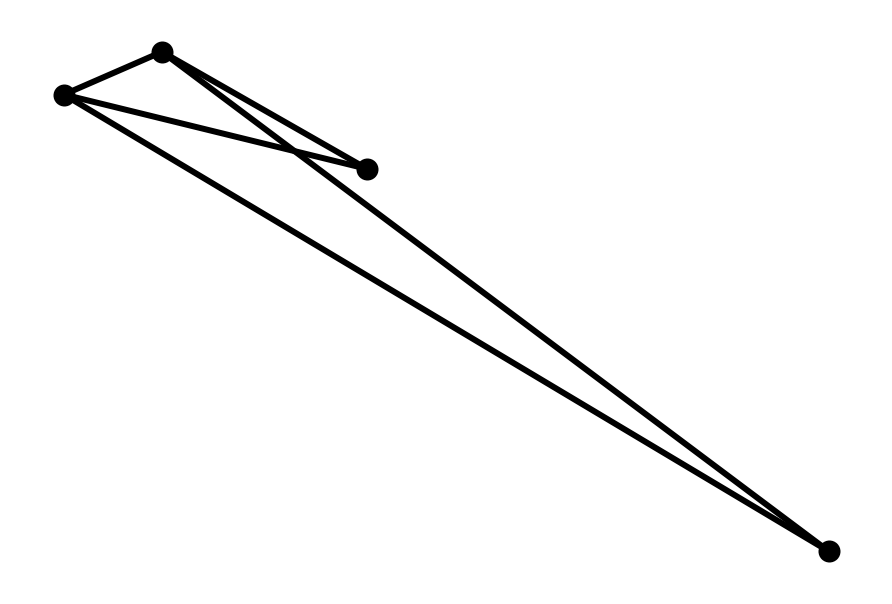

In [38]:
options = {
...     'node_color': 'black',
...     'node_size': 100,
...     'width': 3,
... }
nx.draw_random(G, **options)

Build an 3D-matrix of distances between two consecutive chords

In [13]:
def distance_matrix(listOfChords):
    l1 = []
    l2 = []
    for x in range(1,len(listOfChords)):
        n = listOfChords[x-1]
        m = listOfChords[x]
        matrix = mat(n, m)
        l1.append([sum([row[i] for row in matrix]) for i in range(0,len(n))])
        l2.append(list(map(sum, matrix)))
    return l1, l2

Compute all the distances of two consecutive chords per note. Essentially getting the sum of the row and the collumn for a 2D ChordToChord matrix

In [14]:
dst1, dst2 = distance_matrix(chordListConnect)
print(dst1)
print(dst2)


[[3, 5, 6], [5, 6, 4], [6, 3, 5, 6], [6, 3, 5], [5, 6, 6], [5, 2, 4], [4, 5, 4], [5, 6, 6], [8, 4, 5, 6], [6, 6, 3, 5]]
[[3, 6, 5], [3, 5, 5, 2], [5, 8, 7], [6, 5, 3], [6, 6, 5], [4, 2, 5], [5, 4, 4], [2, 6, 5, 4], [5, 4, 8, 6], [8, 7, 5]]


Getting the index of the minimum element

In [15]:
def noteindex(l):
    k = []
    for i in l:
        k.append(i.index(min(i)))
    return k

Indexing the minimum in collumns and row. That means that I specify the two notes that are closer apart in the Tonnetz grid

In [16]:
listindexN     = noteindex(dst1)
listindexNpls1 = noteindex(dst2)

In [17]:
listOfConnectedNotes = []
for x in range(0,len(chordListConnect)-1):
    k1 = chordListConnect[x]
    k2 = chordListConnect[x+1]
    c1 = k1[listindexN[x]]
    c2 = k2[listindexNpls1[x]]
    listOfConnectedNotes.append((c1,c2))

Here I can find when two graphs are connected or have a bigger distance.

In [18]:
print(listOfConnectedNotes)

[(0, 0), (9, 9), (2, 2), (7, 7), (0, 9), (5, 5), (1, 4), (0, 0), (2, 5), (7, 7)]


Get the interval Vector of previous list :

In [19]:
intervalVectorsOfConnectedNotes = []
for i in listOfConnectedNotes:
    intervalVectorsOfConnectedNotes.append((ms.chord.Chord(i).intervalVectorString))

In [20]:
print(intervalVectorsOfConnectedNotes)
print(listOfConnectedNotes)
print(chordListConnect)

['<000000>', '<000000>', '<000000>', '<000000>', '<001000>', '<000000>', '<001000>', '<000000>', '<001000>', '<000000>']
[(0, 0), (9, 9), (2, 2), (7, 7), (0, 9), (5, 5), (1, 4), (0, 0), (2, 5), (7, 7)]
[[0, 4, 7], [0, 5, 9], [0, 2, 6, 9], [2, 7, 11], [0, 4, 7], [2, 5, 9], [1, 5, 8], [0, 4, 9], [0, 2, 5, 8], [2, 5, 7, 11], [0, 4, 7]]


In [21]:
buildGrid = ((0, 0), (1, 3), (2, 2), (0, 1), (1, 0), (3, 3), (0, 2), (1, 1), (2, 0), (0, 3), (1, 2), (2, 1))

We place the first chord in the grid we defined earlier. The $x$ and $y$ are the placement of a moving box containing the original grid. $k$ signifies the chord we want to place in the grid.

In [50]:
def placeFirstChordInGrid(l, k, grid, x, y):
    coordinates = []
    for i in l[k]:
        coordinates.append(((grid[i])[0]+x, (grid[i])[1]+y))
    return coordinates

In [51]:
placeFirstChordInGrid(chordListConnect, 0, buildGrid, 0, 0)

[(0, 0), (1, 0), (1, 1)]

In [60]:
points = np.array(placeFirstChordInGrid(chordListConnect, 0, buildGrid, 0, 0))
tri = Delaunay(points)

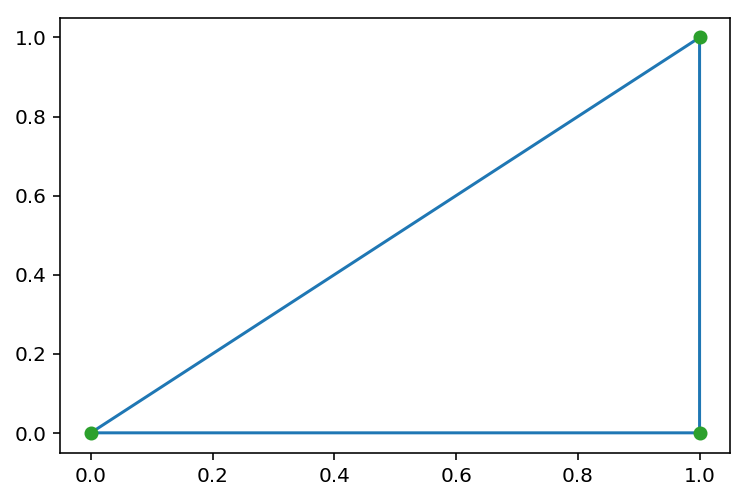

In [61]:
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

True